# Processing of final output

In [27]:
# Traditional imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Music and image specific imports
from music21 import converter, instrument, note, chord, stream
from imageio import imwrite
from PIL import Image, ImageOps

## Create and save image corresponding to arrays from a list of songs

In [44]:
image = ImageOps.grayscale(Image.open('../../data_test/Input_image_cleaned/ballade2/ballade2_instrument_0_0.png'))

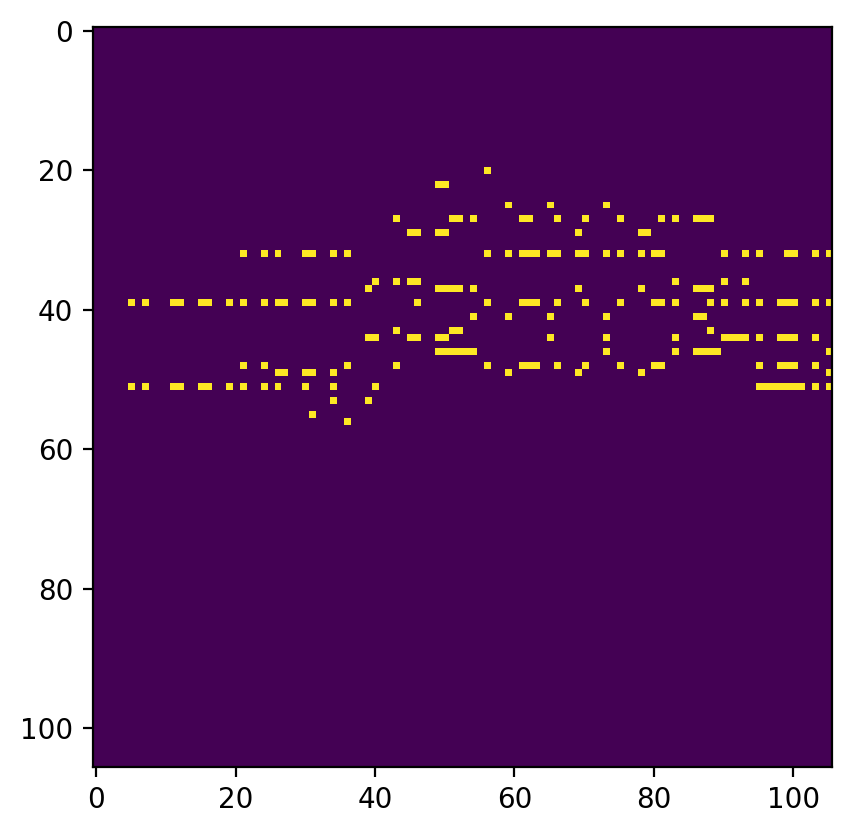

In [46]:
plt.imshow(image)

## Convert created image into a midi file

In [7]:
# Intermediary function
def column2notes(column, lowerBoundNote = 21):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

In [8]:
# Intermediary function
def updateNotes(newNotes,prevNotes, resolution = 0.25): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

In [12]:
image = Image.open('../../data_test/Input_image_cleaned/ballade2/ballade2_instrument_0_0.png').convert('1')

In [41]:
def image2midi(image_path, output_folder_path, lowerBoundNote = 21, resolution = 0.25):
    """
    Convert one image (located at 'image_path') into a midi file and store it in the folder located at 'output_folder_path'
    """
    
    output_folder = f"{output_folder_path}{image_path.split('/')[-1].replace('.mid', '')}"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    image = ImageOps.grayscale(Image.open(image_path)) # Opening image as a black and white image
    im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
    im_arr = np.squeeze(im_arr)

    try:
        im_arr = im_arr.reshape((image.size[1], image.size[0]))
    except:
        im_arr = im_arr.reshape((image.size[1], image.size[0],3))
        im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column, lowerBoundNote=lowerBoundNote)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes, resolution=resolution)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    output_filename = os.path.join(output_folder, image_path.split("/")[-1].replace(".png",".mid"))
    midi_stream.write('midi', fp=output_filename)

In [48]:
# Testing the function on a cleaned image
image_path = '../../data_test/Input_image_cleaned/ballade2/ballade2_instrument_0_0.png'
output_folder_path = '../../data_test/Output_midi/'
image2midi(image_path, output_folder_path)